### General Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import glob
import json
import matplotlib.pyplot as plt
from cleanUp import cleanUp

### Data Cleaning
Passing the sensor data through the cleanUp function to get fix timestamps and delete null timestamps.

In [2]:
all_csv_files = glob.glob("./Data/*.txt")
loops=len(all_csv_files)
# insert the desired start time
cutOffTime = '12/22/2020 12:49'
# insert the time rectifying offsets. default of for nothing {'':0}
sensorConditions = {'BU':8,'S-':1}
columns = [0,1,6,7,8,9,10,11]

In [3]:
data = cleanUp(cutOffTime,sensorConditions,all_csv_files,columns)

S-01     2020-12-22 12:49:10      2020-12-22 16:09:31
S-02  NO DATA PRESENT    NO DATA PRESENT
S-03     2020-12-22 12:49:03      2020-12-22 16:09:35
S-04     2020-12-22 12:49:07      2020-12-22 16:09:34
S-05     2020-12-22 12:49:01      2020-12-22 16:10:50
S-06     2020-12-22 12:49:12      2020-12-22 16:09:25
S-07     2020-12-22 12:49:07      2020-12-22 16:12:53
S-08     2020-12-22 12:49:24      2020-12-22 16:57:24
S-09     2020-12-22 12:49:00      2020-12-22 16:11:30
S-11     2020-12-22 13:02:00      2020-12-22 16:09:43
S-12     2020-12-22 12:49:06      2020-12-22 16:10:06
S-13     2020-12-22 12:49:06      2020-12-22 16:08:44
S-14     2020-12-22 12:49:09      2020-12-22 16:13:45
S-15     2020-12-22 12:49:03      2020-12-22 16:10:00
S-BU1     2020-12-22 12:49:00      2020-12-22 16:11:40
S-BU2     2020-12-22 12:49:00      2020-12-22 16:10:30


### Exporting Data
Here we can export the organized data frames as csv files

In [4]:
for x in data:
    temp=data[x]
    location = os.path.join('./proccessedData',x+'.csv')
    temp.to_csv(location,index=False)

### Checking Data
Here we scan through the data for irregularities in data recording.

In [5]:
errors = {}
errorCount = {}
# Enter the expected interval here
interval = 10
for x in data:
    # errors keeps track of length of each time interval error that occurs
    errors[x] = set(())
    # errorCount keeps track of how many times each time interval error occured
    errorCount[x] = {}
    # counter keeps track of the total time interval errors per sensor
    counter = 0
    temp = data[x]
    for idx,i in enumerate(temp['Date_Time']):
        try:
            if not ((temp['Date_Time'][idx+1] - i) == pd.Timedelta(seconds=interval)):
                timeErr = temp['Date_Time'][idx+1] - i
                if str(timeErr.seconds) in errorCount[x]:
                    errorCount[x][str(timeErr.seconds)] +=1
                else:
                    errorCount[x][str(timeErr.seconds)] = 1

                errors[x].add(timeErr)


                counter += 1
        except:
            continue

    print(str(counter),' possible errors in ', x)
    # display the different types of errors
    lst = [i.seconds for i in errors[x]]
    frmt = "{:>4}"*len(lst)
    print(frmt.format(*lst))
    # display the quantity of each type of error
    lst = [errorCount[x][str(i.seconds)] for i in errors[x]]
    frmt = "{:>4}"*len(lst)
    print(frmt.format(*lst))
    print()

208  possible errors in  S-01
  26  21  17  13  19  30  20  11
   1   1   6   1   2   1 195   1

0  possible errors in  S-02



219  possible errors in  S-03
  21  12  25  27  16  18  62  84  51  20  31  11  22   9  13   0  90  15  70  59  17  19  63
   1   2   1   2   1   7   2   1   1 171   1   3   2   1   1   1   1   1   1   1  12   4   1

220  possible errors in  S-04
  21  22  17  23  60  18  35  24  78  19  20  13  25  11  49
   1   2  12   1   1  10   3   1   1   2 180   1   1   3   1

220  possible errors in  S-05
  26  21  16  17  23  12  18   7  19  24  25  20  15
   1   4   1  10   2   1   7   1   2   1   1 188   1

199  possible errors in  S-06
  28  20  85
   1 197   1

212  possible errors in  S-07
   9  16  22  14  12  34  18  24  19  30  25  20  15  17  13  11
   1   1   2   1   1   1   1   1   9   2   1 184   2   2   1   2

412  possible errors in  S-08
  34  35 138 139 140  37
 164 241   3   2   1   1

5  possible errors in  S-09
   9  17   3  31  20
   1   1   1   1 

Notice there are quite a few repeating errors here in our data set. We can either choose to interpolate the data inbetween or pad it with 0s. For gaps <40s i will interpolate, but for gaps >40 i will 0 pad.

In [180]:
def fillDf(df,freq):
    index = pd.date_range(df.values[0][0], df.values[-1][0], freq=freq)
    columns = df.columns

    count = 0

    overall = []

    for idx, i in enumerate(df.values):
        oldCount = count
        # print(count)
        try:
            while i[0] >= index[count]:
                count+=1
        except IndexError:
            print(i)
            print(val)
            print(temp)
            print(inc)
            continue
        val = count - oldCount

        if pd.Timedelta(seconds=40) < (index[count] - index[oldCount]):
            for step, ovrwrt in enumerate(range(oldCount,count)):
                tempdata = np.concatenate((np.array([index[ovrwrt]]),np.floor(np.array(temp*0))),0)
                overall.append(tempdata)
            val = 0


        # might error on first value

        if val and val - 1:
            
            if not idx:
                temp = df.values[0][1:]
            else:    
                temp = df.values[idx-1][1:]
            inc = (i[1:] - temp)/val

            for step, ovrwrt in enumerate(range(oldCount,count)):
                tempdata = np.concatenate((np.array([index[ovrwrt]]),np.floor(np.array(temp+inc*step))),0)
                overall.append(tempdata)

        elif val:
            temp = i[1:]
            tempdata = np.concatenate((np.array([index[oldCount]]),np.floor(np.array(temp))),0)
            overall.append(tempdata)
        else:
            temp = i[1:]
            tempdata = np.concatenate((np.array([index[oldCount]]),np.floor(np.array(temp))),0)
            overall.append(tempdata)
    print(i)
    print(val)
    print(temp)
    print(inc)
            
    newDF = pd.DataFrame(overall,columns = columns)

    return newDF

In [182]:
df = data['S-BU2']
# cutoff = 40
freq = '10S'
a = fillDf(df,freq)

[Timestamp('2020-12-22 16:10:30') 1839 451 0 0 0 0]
3
[660 128 0 0 0 0]
[151.0 40.0 0.0 0.0 0.0 0.0]
[Timestamp('2020-12-22 16:10:30') 1839 451 0 0 0 0]
3
[660 128 0 0 0 0]
[151.0 40.0 0.0 0.0 0.0 0.0]


In [177]:
a

,Date_Time,Dp>0.3,Dp>0.5,Dp>1.0,Dp>2.5,Dp>5.0,Dp>10.0
0,2020-12-22 12:49:10,0,0,0,0,0,0
1,2020-12-22 12:49:20,9,0,0,0,0,0
2,2020-12-22 12:49:30,9,0,0,0,0,0
3,2020-12-22 12:49:40,0,0,0,0,0,0
4,2020-12-22 12:49:50,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1197,2020-12-22 16:08:40,48,13,0,0,0,0
1198,2020-12-22 16:08:50,9,3,0,0,0,0
1199,2020-12-22 16:09:00,0,0,0,0,0,0
1200,2020-12-22 16:09:10,0,0,0,0,0,0


In [179]:
data['S-01']

,Date_Time,Dp>0.3,Dp>0.5,Dp>1.0,Dp>2.5,Dp>5.0,Dp>10.0
0,2020-12-22 12:49:10,0,0,0,0,0,0
1,2020-12-22 12:49:20,9,0,0,0,0,0
2,2020-12-22 12:49:30,9,0,0,0,0,0
3,2020-12-22 12:49:40,0,0,0,0,0,0
4,2020-12-22 12:49:50,0,0,0,0,0,0
...,...,...,...,...,...,...,...
992,2020-12-22 16:08:41,48,13,0,0,0,0
993,2020-12-22 16:08:51,9,3,0,0,0,0
994,2020-12-22 16:09:01,0,0,0,0,0,0
995,2020-12-22 16:09:21,0,0,0,0,0,0


In [108]:
index = pd.date_range(df.values[0][0], df.values[-1][0], freq=freq)

In [111]:
index

DatetimeIndex(['2020-12-22 12:49:00', '2020-12-22 12:49:10',
               '2020-12-22 12:49:20', '2020-12-22 12:49:30',
               '2020-12-22 12:49:40', '2020-12-22 12:49:50',
               '2020-12-22 12:50:00', '2020-12-22 12:50:10',
               '2020-12-22 12:50:20', '2020-12-22 12:50:30',
               ...
               '2020-12-22 16:09:00', '2020-12-22 16:09:10',
               '2020-12-22 16:09:20', '2020-12-22 16:09:30',
               '2020-12-22 16:09:40', '2020-12-22 16:09:50',
               '2020-12-22 16:10:00', '2020-12-22 16:10:10',
               '2020-12-22 16:10:20', '2020-12-22 16:10:30'],
              dtype='datetime64[ns]', length=1210, freq='10S')

In [159]:
temp =  data['S-01'].values[0]
overall = []
for i in range(3):
    overall.append(temp)
pd.DataFrame(overall)



,0,1,2,3,4,5,6
0,2020-12-22 12:49:10,0,0,0,0,0,0
1,2020-12-22 12:49:10,0,0,0,0,0,0
2,2020-12-22 12:49:10,0,0,0,0,0,0


In [307]:
ar = np.concatenate((np.array([pd.Timestamp('12/22/2020')]),data['S-01'].values[0][1:]),0)
print(np.array([pd.Timestamp('12/22/2020')]))

[Timestamp('2020-12-22 00:00:00')]


In [179]:
data['S-01'].values[0][1:]

array([0, 0, 0, 0, 0, 0], dtype=object)

In [81]:
if 1 and 1:
    print('riun')

riun


In [83]:
temp =[]
temp = (data['S-05'].values[-1][1:]+data['S-05'].values[-1][1:])/2
temp +=data['S-05'].values[-1][1:]
np.floor(temp)

array([168, 38, 0, 0, 0, 0], dtype=object)

In [52]:
pd.date_range(data['S-07'].values[0][0], data['S-08'].values[-1][0], freq='10S')

DatetimeIndex(['2020-12-22 12:49:07', '2020-12-22 12:49:17',
               '2020-12-22 12:49:27', '2020-12-22 12:49:37',
               '2020-12-22 12:49:47', '2020-12-22 12:49:57',
               '2020-12-22 12:50:07', '2020-12-22 12:50:17',
               '2020-12-22 12:50:27', '2020-12-22 12:50:37',
               ...
               '2020-12-22 16:55:47', '2020-12-22 16:55:57',
               '2020-12-22 16:56:07', '2020-12-22 16:56:17',
               '2020-12-22 16:56:27', '2020-12-22 16:56:37',
               '2020-12-22 16:56:47', '2020-12-22 16:56:57',
               '2020-12-22 16:57:07', '2020-12-22 16:57:17'],
              dtype='datetime64[ns]', length=1490, freq='10S')

In [19]:
asd = -14
for i in data['S-05'].values:
    print(i)
    asd += 1
    if not asd:
        break

[Timestamp('2020-12-22 12:49:01') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:49:21') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:49:31') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:49:41') 9 3 0 0 0 0]
[Timestamp('2020-12-22 12:49:51') 9 0 0 0 0 0]
[Timestamp('2020-12-22 12:50:01') 18 3 0 0 0 0]
[Timestamp('2020-12-22 12:50:21') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:50:31') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:50:41') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:50:51') 9 3 0 0 0 0]
[Timestamp('2020-12-22 12:51:01') 9 3 0 0 0 0]
[Timestamp('2020-12-22 12:51:21') 0 0 0 0 0 0]
[Timestamp('2020-12-22 12:51:31') 36 12 0 0 0 0]
[Timestamp('2020-12-22 12:51:41') 27 9 0 0 0 0]


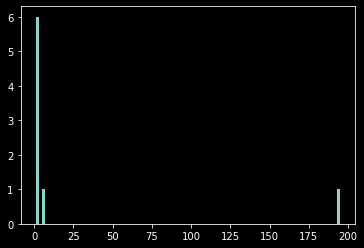

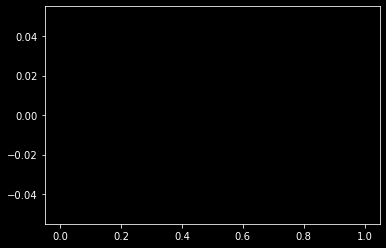

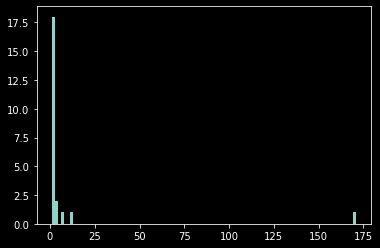

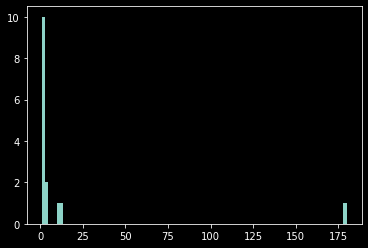

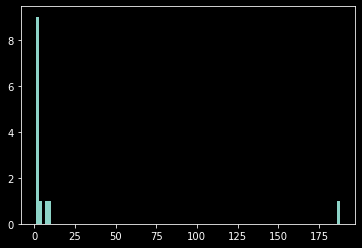

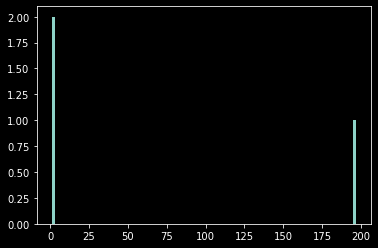

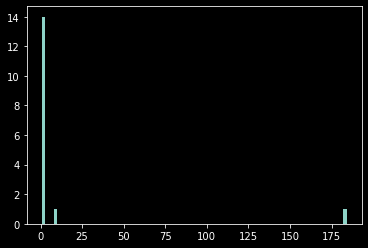

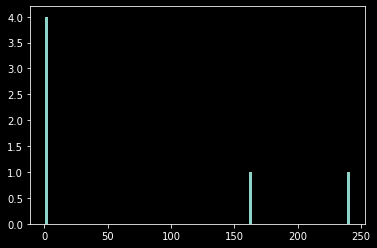

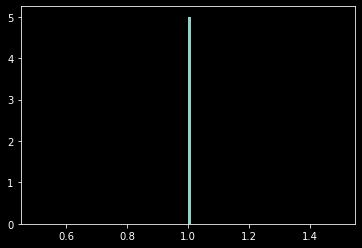

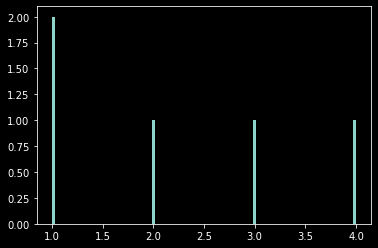

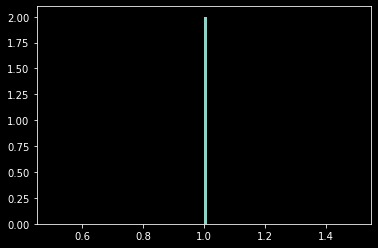

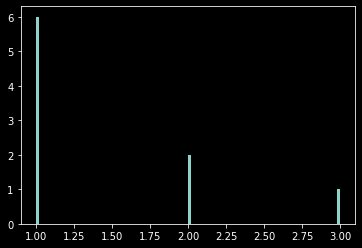

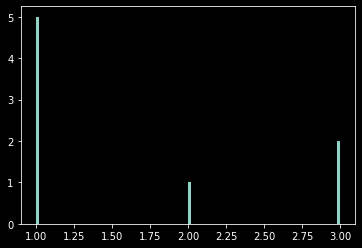

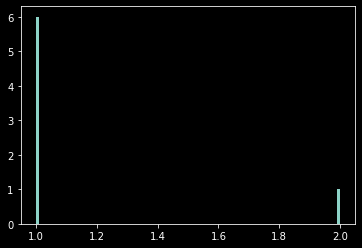

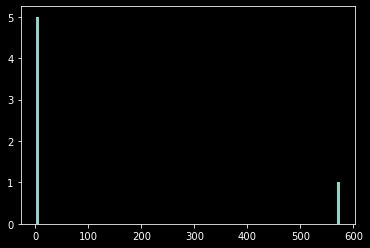

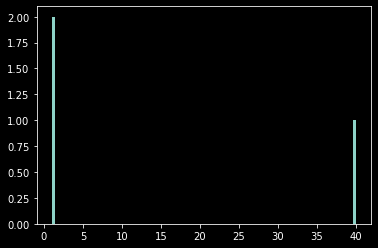

In [6]:
for idx,x in enumerate(data):
    fig = plt.figure(idx)
    ax = fig.gca()
    plt.hist([errorCount[x][str(i.seconds)] for i in errors[x]],bins=100)
    plt.show